# Statistical Analysis of Temperature Data

<b> YouTube Tutorial </b> (Published: Jul 6, 2022): https://youtu.be/4zV-ZyQHl7s

In part 2 of this weather derivative series, our goal is to:
1. complete statistical analysis on temperature data
2. de-trend and remove seasonality using statsmodels decompose function [classical decomposition using moving averages](https://stackoverflow.com/questions/47076771/statsmodels-seasonal-decompose-what-is-naive-about-it)

### Quick Summary - our goal:

<b>Aim</b>: we want to price temperature options.

<b>Underlying</b>: HDD/CDD index over given period.

The underlying over a temperature option is the heating/cooling degree days (HDD/CDD) index based on 'approximation' of average temperature and reference (/base) temperature.

$\large T_n = \frac{T^{max}+T^{min}}{2}$

For an individual day $n \in N$:
- $\large HDD_n = (T_{ref}-T_n)^+$
- $\large CDD_n = (T_n - T_{ref})^+$

HDD/CDD Index for a given period $N$:
- $\large DD = H_n = HDD^{N} = \sum^N_n HDD_n$
- $\large DD = C_n = CDD^{N} = \sum^N_n CDD_n$

<b>Option Payoff</b>: $\large \xi = f(DD)$

<b>Example of popular OTC product</b>: Call with Cap

$\large \xi = min\{\alpha(DD - K)^+, C\}$

<i>where:</i>
 - payoff rates $\large \alpha$ is commonly US$\$2,500$ or US$\$5,000$ [1]
 - while caps $\large C$ is commonly US$\$500,000$ or US$\$1,000,000$ [1]

<b>References:</b>

[1] Statistical Analysis of Financial Data in R (Rene Carmona, 2014)

### Dataset

Weather Observations for Sydney, Australia - [Observatory Hill:](http://www.bom.gov.au/climate/data/stations/)

<img src='data quality.png'>

Dataset Start to End:
- Weather Station 1: 1-Jan 1859 - 30-Aug 2020
- Weather Station 2: 18-Oct 2017 - 3-Jul 2022

Data available:
- Maximum Temperature
- Minimum Temperature

In [ ]:
%%html
<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d13656431.793916743!2d128.83616311102875!3d-27.706628814419133!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x6b12ae4378d6a067%3A0xf017d68f9f1ef60!2sObservatory%20Hill%20Park!5e0!3m2!1sen!2sau!4v1656985720473!5m2!1sen!2sau" width="600" height="450" style="border:0;" allowfullscreen="" loading="lazy" referrerpolicy="no-referrer-when-downgrade"></iframe>

In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

In [ ]:
max_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y


## Check for missing data

In [ ]:
max_temp.isnull().value_counts(),min_temp.isna().value_counts()

(Product code  Bureau of Meteorology station number  Year   Month  Day    Maximum temperature (Degree C)  Days of accumulation of maximum temperature  Quality
 False         False                                 False  False  False  False                           False                                        False      59428
                                                                          True                            True                                         True         151
                                                                          False                           True                                         False        135
                                                                                                          False                                        True           2
                                                                          True                            False                                        True           2
 

Are these the same days? If not will have to drop all rows (days) with at least value missing.

In [ ]:
count = 0
for mx, mn in zip(np.where(max_temp.isnull())[0], np.where(min_temp.isnull())[0]):
    if mx != mn:
        count += 1

print('Number of Misaligned Null Values: ', count)

Number of Misaligned Null Values:  41


### Create cleaned max min temperature dataframe

In [ ]:
def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

In [ ]:
max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

In [ ]:
temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


In [ ]:
temps.describe()

,Tmax,Tmin,T
count,59557.000000,59557.000000,59557.000000
mean,21.765421,13.822060,17.793740
std,4.671480,4.441057,4.294937
min,7.700000,2.100000,6.400000
25%,18.300000,10.100000,14.200000
50%,21.700000,14.000000,17.900000
75%,24.900000,17.500000,21.100000
max,45.800000,27.600000,33.750000


### Indicate winter and summer periods

Here in Australia:
1. Winter ~ May-Oct
2. Summer ~ Nov-Apr

In [ ]:
temps_season = temps.copy(deep=True)
temps_season['month'] = temps_season.index.month
mask = (temps_season['month'] >= 5) & (temps_season['month'] <= 10)
temps_season['winter'] = np.where(mask,1,0)
temps_season['summer'] = np.where(temps_season['winter'] != 1,1,0)
temps_season

,Tmax,Tmin,T,month,winter,summer
Date,,,,,,
1859-01-01,24.4,14.5,19.45,1,0,1
1859-01-02,24.4,15.7,20.05,1,0,1
1859-01-03,24.2,15.3,19.75,1,0,1
1859-01-04,24.7,17.4,21.05,1,0,1
1859-01-05,24.6,16.9,20.75,1,0,1
...,...,...,...,...,...,...
2022-06-29,17.9,8.0,12.95,6,1,0
2022-06-30,16.9,10.2,13.55,6,1,0
2022-07-01,12.0,10.3,11.15,7,1,0


### Data Visualisation

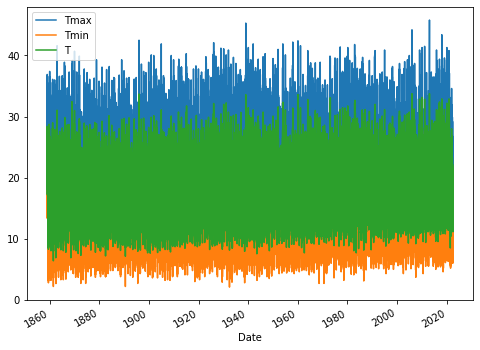

In [ ]:
temps[:].plot(figsize=(8,6))
plt.show()

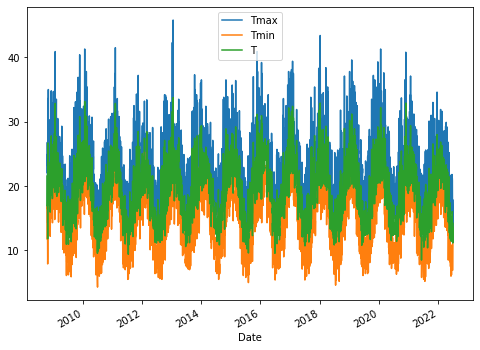

In [ ]:
temps[-5000:].plot(figsize=(8,6))
plt.show()

###  Temperature distributions

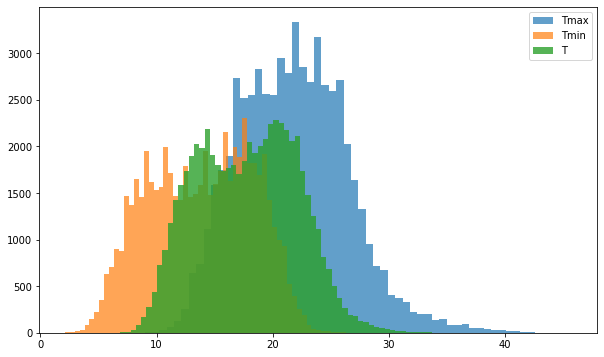

In [ ]:
plt.figure(figsize=(10,6))
temps.Tmax.hist(bins=60, alpha=0.7, label='Tmax')
temps.Tmin.hist(bins=60, alpha=0.7, label='Tmin')
temps['T'].hist(bins=60, alpha=0.8, label='T')
plt.grid(False)
plt.legend()
plt.show()

### Bimodal Distribution
The two peaks reflect both the summer and winter months.

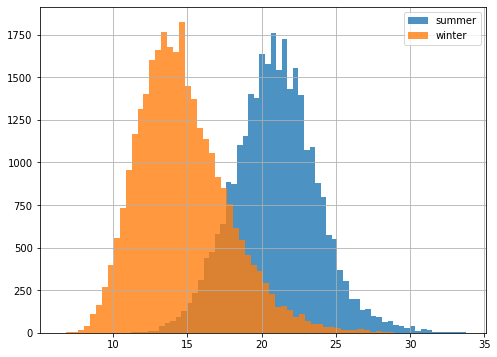

In [ ]:
plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='summer')
temps_season[temps_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

### Temperature Records

Compile list of min and max records for each month on record.

In [ ]:
date_list = temps.index.tolist()
mth_temps = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_temps['month'] = mth_temps.index.month
def min_max_temps(row):
    stats = temps[(temps.index >= row['min']) & (temps.index <= row['max'])].agg([min, max])
    row['Tmax_max'] = stats.loc['max', 'Tmax']
    row['Tmax_min'] = stats.loc['min', 'Tmax']
    row['Tmin_max'] = stats.loc['max', 'Tmin']
    row['Tmin_min'] = stats.loc['min', 'Tmin']
    row['T_max'] = stats.loc['max', 'T']
    row['T_min'] = stats.loc['min', 'T']
    return row

mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps

,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,T_max,T_min
1859-01-01,1859-01-01,1859-01-31,1,36.9,20.6,19.9,14.5,28.40,18.10
1859-02-01,1859-02-01,1859-02-28,2,35.6,19.9,20.0,13.3,26.95,17.25
1859-03-01,1859-03-01,1859-03-31,3,30.4,18.8,18.9,13.3,23.55,17.10
1859-04-01,1859-04-01,1859-04-30,4,31.1,16.8,17.7,7.8,22.45,13.25
1859-05-01,1859-05-01,1859-05-31,5,28.6,13.9,16.7,4.6,22.65,9.25
...,...,...,...,...,...,...,...,...,...
2022-03-01,2022-03-01,2022-03-31,3,28.6,21.5,21.4,15.1,24.45,19.50
2022-04-01,2022-04-01,2022-04-30,4,29.9,18.2,17.9,13.1,23.30,15.90
2022-05-01,2022-05-01,2022-05-31,5,26.8,14.9,18.2,8.2,21.45,12.05
2022-06-01,2022-06-01,2022-06-30,6,21.8,15.0,10.9,6.0,16.05,11.30


### Let's look at the Temperature Extreme's on record

Now we can group on whichever seasons we would like, so here we aggregate on months from 1857-2022 to get the:
- maximum Tmax's
- minimum Tmin's

Also interesting to inspect
- maximum Tmin's
- minimum Tmax's

In [ ]:
grouped_mths = mth_temps.groupby(mth_temps.month)[['Tmax_max', 'Tmax_min', 'Tmin_max', 'Tmin_min','T_max','T_min']].agg([min, max])
grouped_mths['months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouped_mths = grouped_mths.set_index('months')
grouped_mths[[('Tmax_max', 'max'),('Tmin_min', 'min'),('Tmax_min', 'min'),('Tmin_max', 'max')]]

,Tmax_max,Tmin_min,Tmax_min,Tmin_max
,max,min,min,max
months,,,,
Jan,45.8,10.6,17.2,26.2
Feb,42.1,9.6,15.6,27.6
Mar,39.8,9.3,16.2,25.4
Apr,35.4,7.0,13.8,24.3
May,30.0,4.4,11.3,20.8
Jun,26.9,2.1,9.7,18.4
Jul,26.5,2.2,7.7,18.1
Aug,31.3,2.7,9.1,19.7


### Let's look at our Temperature Options Underlying: "Avg Temp"

This time we will look at the max and min's for both T_max and T_min for each month on record. Again we aggregate on months from 1857-2022 to get the:
- maximum T_max's
- minimum T_min's

Also interesting to inspect
- maximum T_min's
- minimum T_max's

In [ ]:
grouped_mths[[('T_max', 'max'),('T_max', 'min'),('T_min', 'max'),('T_min', 'min')]]

T_max         T_min       
          max    min    max    min
months                            
Jan     33.75  22.75  21.95  15.05
Feb     33.10  23.20  21.95  12.60
Mar     31.75  22.15  20.65  13.10
Apr     29.10  19.45  18.20  11.20
May     24.55  16.20  14.95   9.20
Jun     21.60  13.25  12.90   7.80
Jul     20.90  12.35  12.50   6.40
Aug     25.05  14.45  12.45   7.30
Sep     26.90  17.25  15.25   7.85
Oct     30.55  19.05  17.50   9.90
Nov     32.90  20.40  18.35  12.45
Dec     32.60  22.05  20.40  14.00

## Decompose Time-Series Components

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise.

1. Trend: decreasing, constant, or increasing over time?
2. Seasonality: what is the periodic signal?
3. Noise: variability in the data that cannot be explained by the model

### statsmodels: [seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

This is a naive decomposition - [classical decomposition](https://otexts.com/fpp2/classical-decomposition.html). More sophisticated methods should be preferred.

The additive model is $y_t = T_t + S_t + e_t$

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component. The steps in classical decomposition are as follows:
1) compute the trend-cycle component $\hat{T_t}$ using an m-MA (moving average)
2) calculate de-trended series $y_t - \hat{T_t}$
3) estimate seasonal component $\hat{S_t}$, by averaging the detrended values for that season (in our case, this is each day of the year). Seasonal component values are adjusted to ensure they add to zero.
4) the remainder is calculated $e_t = y_t - \hat{T_t} - \hat{S_t}$



In [ ]:
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

In [ ]:
temps.sort_index(inplace=True)
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


### Clear upward trend in temperature over time

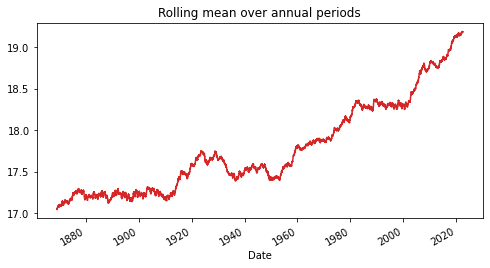

In [ ]:
temps['T'].rolling(window = 365*10).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")

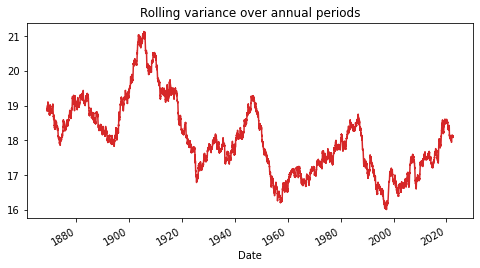

In [ ]:
temps['T'].rolling(window = 365*10).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over annual periods");

### Use seasonal_decompose function

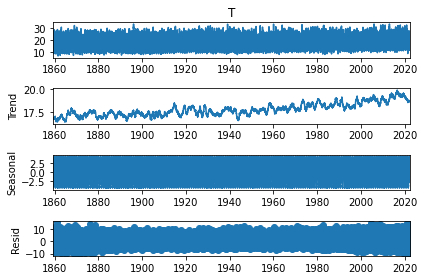

In [ ]:
decompose_result = seasonal_decompose(temps['T'], model='additive', period=int(365), extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()
plt.show()

### Visualise 10 years

(-15.0, 15.0)

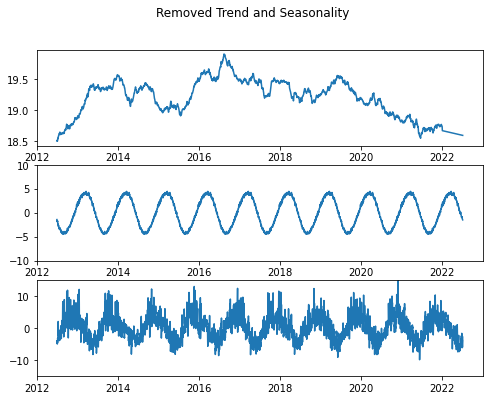

In [ ]:
years_examine = 365*10
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Removed Trend and Seasonality')
axs[0].plot(trend[-years_examine:])
axs[1].plot(seasonal[-years_examine:])
axs[1].set_ylim([-10,10])
axs[2].plot(residual[-years_examine:])
axs[2].set_ylim([-15,15])

### Check residual distribution

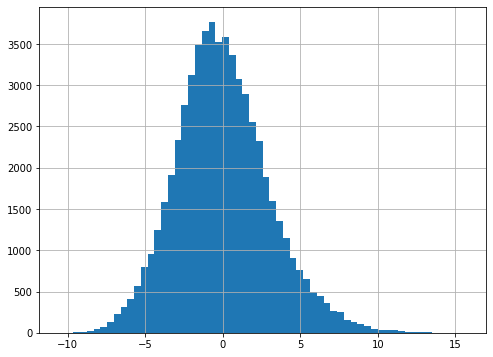

In [ ]:
residual.hist(bins=60, figsize=(8,6))

### Testing for Stationarity with Dicky-Fuller
We can perform Dicky-Fuller test functionality available with the statsmodels library. Below we'll test the stationarity of our time-series with this functionality and try to interpret its results to better understand it.

Unit Root Test, null hypothesis is that unit root exists.

In [ ]:
dftest = adfuller(residual, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -20.71088609181375
2. P-Value :  0.0
3. Num Of Lags :  60
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59496
5. Critical Values :
	 1% :  -3.4304599163331826
	 5% :  -2.861588580932765
	 10% :  -2.5667958579940375


## Analysis of Serial Correlations
Below we are also plotting auto-correlation plot for time-series data as well. This plot helps us understand whether present values of time-series are positively correlated, negatively correlated or not related at all with past values.

statsmodels library provides ready to use method plot_acf as a part of module statsmodels.graphics.tsaplots

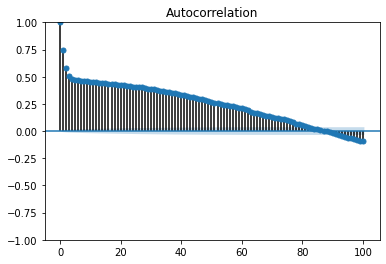

In [ ]:
plot_acf(residual, lags=100)
plt.show()

Above we can see significant serial correlation. Since the auto-correlation funtion does not seem to vanish after after a finite number of lags, we do not try and fit a moving average model.

### Determine AR order by use of PACF & AIC Criterion

[PACF](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=ACF%20considers%20all%20these%20components,a%20partial%20auto%2Dcorrelation%20function) is a partial auto-correlation function. Basically instead of finding correlations of present values with lags like ACF, it finds correlation of the residuals.

These residuals remain after removing the effects which are already explained by the earlier lag(s) with the next lag value. i.e. We remove already found variations before we find the next correlation.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


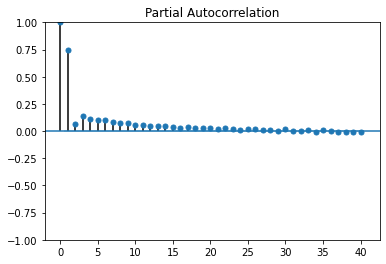

In [ ]:
plot_pacf(residual, lags=40)
plt.show()

### Akaike Information Criterion (AIC)

[AIC](https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced) is a single number score that can be used to determine which of multiple models is most likely to be the best model for a given dataset. AIC works by evaluating the model’s fit on the training data, and adding a penalty term for the complexity of the model.

$\large AIC = -2ln(L) + 2k$

AIC equation, where L = likelihood and k = # of parameters. AIC uses a model’s maximum likelihood estimation (log-likelihood) as a measure of fit. Log-likelihood is a measure of how likely one is to see their observed data, given a model. The model with the maximum likelihood is the one that “fits” the data the best.

The desired result is to find the lowest possible AIC, which indicates the best balance of model fit with generalizability. This serves the eventual goal of maximizing fit on out-of-sample data.

In [ ]:
residuals = residual.copy(deep=True)
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


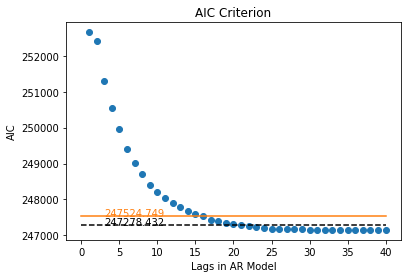

In [ ]:
mod = ar_select_order(residuals, maxlag=40, ic='aic', old_names=True)

aic = []
for key, val in mod.aic.items():
    if key != 0:
        aic.append((key[-1], val))

aic.sort()
x,y = [x for x,y in aic],[y for x,y in aic]

plt.scatter(x, y)
plt.plot([0,40],[y[15],y[15]], 'tab:orange')
plt.text(3,y[15]+0.002, '{0}'.format(round(y[15],3)),color='tab:orange')
plt.plot([0,40],[y[20],y[20]], 'k--')
plt.text(3,y[20]-0.004, '{0}'.format(round(y[20],3)))
plt.title("AIC Criterion")
plt.xlabel("Lags in AR Model")
plt.ylabel("AIC")
plt.show()

### Fitting a AR with lags=15
[Interpreting the results](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a) with statsmodels .summary()

In [ ]:
model = AutoReg(residuals, lags=15, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                59557
Model:                    AutoReg(15)   Log Likelihood             -123832.810
Method:               Conditional MLE   S.D. of innovations              1.936
Date:                Wed, 06 Jul 2022   AIC                         247697.619
Time:                        07:59:40   BIC                         247841.530
Sample:                    01-16-1859   HQIC                        247742.336
                         - 07-03-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.6139      0.004    149.905      0.000       0.606       0.622
resid.L2      -0.0515      0.005    -10.712      0.000      -0.061      -0.042
resid.L3       0.0360      0.005      7.494      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


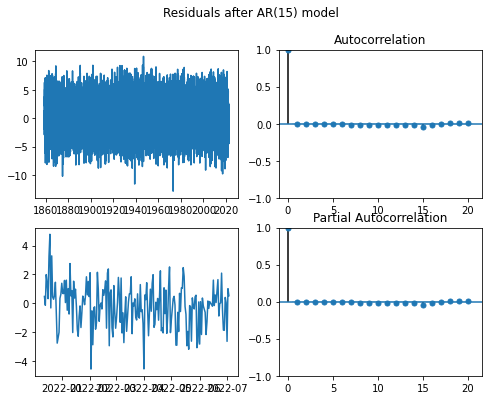

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(15) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

The auto-correlation function of the raw residuals of the AR(15) model fitted to the remainder component of the daily temperature in Sydney, looks like white noise now!
The serial correlation in the data appears to have been captured by the AR(15) model.

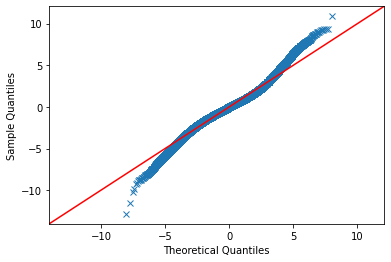

In [ ]:
from scipy.stats import norm
qqplot(res, marker='x', dist=norm, loc=0, scale=np.std(res), line='45')
plt.show()